In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

<h1  style="color:white; background-color:blue; padding:50px; border-radius: 10px;">    
Préambule (fonctions utiles )
</h1>

On définit nos fonctions d'erreurs

In [2]:
def kaggle_error_vrai(Ypred,Yvrai):
    Ypred= pd.DataFrame(Ypred)
    Yvrai= pd.DataFrame(Yvrai)
    n = Yvrai.shape[0]
    m=0
    #print(n)
    res= 0
    for i in range(n):
        if Yvrai.iloc[i,0] != 0: # Pcq pour la pred finale, on fixera à la main les vlaurs 0 lorsque boutique fermé
            res += ( (Yvrai.iloc[i,0] - Ypred.iloc[i,0]) / Yvrai.iloc[i,0])**2
            m += 1
    if m != 0:
        return np.sqrt((1/m)*res)
    else:
        return 0

In [3]:
#ici 1/n[...] et pas 1/m[...], donc on aura un eilleur score (plus petit)
def kaggle_error_vrai_2(Ypred,Yvrai):
    Ypred= pd.DataFrame(Ypred)
    Yvrai= pd.DataFrame(Yvrai)
    n = Yvrai.shape[0]
    m=0
    #print(n)
    res= 0
    for i in range(n):
        if Yvrai.iloc[i,0] != 0: # Pcq pour la pred finale, on fixera à la main les vlaurs 0 lorsque boutique fermé
            res += ( (Yvrai.iloc[i,0] - Ypred.iloc[i,0]) / Yvrai.iloc[i,0])**2
            m += 1
    return np.sqrt((1/n)*res)

<h1  style="color:white; background-color:blue; padding:50px; border-radius: 10px;">    
I - Gestion et traitement de la donnée
</h1>


https://github.com/NikhitaMethwani/Rossman-Sales-Prediction---Time-Series/blob/master/Rossman_Sales_Prediction.ipynb


########################Modeles en mode times series###############################
https://colab.research.google.com/github/RPI-DATA/tutorials-intro/blob/master/website/Forecasting%20the%20Rossmann%20Store%20Sales.ipynb#scrollTo=qCUy3qWVKxTj





#######################Modelèes basiques avec temps pris en compte#############################
https://serhanaya.github.io/posts/kaggle-rossmann-sales-prediction/
     
https://medium.com/analytics-vidhya/rossmann-store-sales-prediction-998161027abf #avec expression kaggle error
#il y a un meta model intéressant ici à la fin + des cores de plusieurs types de modèles

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Ouverture et fusion des tables train, test avec store </h1>

In [4]:
train = pd.read_csv('./data/train.csv', low_memory=False, parse_dates=['Date'],sep=",")# le database fourni
test = pd.read_csv('./data/test.csv',sep=",")# le database fourni
store = pd.read_csv('./data/store.csv',sep=",")# le database fournit
train.head()
#train.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
train_store = train.merge(store, how='inner',on='Store')
#train_store.head()

In [6]:
##########Onsupprime les colonnes dont on ne veut pas se servir#########
train2=train_store.drop(['Customers','Promo2SinceWeek','Promo2SinceYear'],axis=1)

######################################On fill les na######################
train2.fillna(value=train2[['CompetitionDistance']].mean(),inplace=True)
train2.fillna(value=train2[['CompetitionOpenSinceMonth']].mean(),inplace=True)
train2.fillna(value=train2[['CompetitionOpenSinceYear']].mean(),inplace=True)

Promo = train2['PromoInterval'].map({ float('nan'): 0, 'Jan,Apr,Jul,Oct': 1,
                                                             'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec': 3})
#Promo
train2[['Promo2']]=Promo
train2.drop(['PromoInterval'],axis=1,inplace=True)
train2.rename(columns={'Promo2':'Promo'}, inplace=True)


######On tranformes variables qualitatives en variables quantitatives########
train2['StateHoliday'] = train2['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3})
train2['StoreType'] = train2['StoreType'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3})
train2['Assortment'] = train2['Assortment'].map({'a': 0, 'b': 1, 'c': 2})

In [7]:
#train2.info()

In [8]:
#train2.head()

from sklearn.preprocessing import StandardScaler

tmp_store=train2[['Store']]
std_scaler = StandardScaler()
train2_scaled = std_scaler.fit_transform(train2.drop(['Store'],axis=1).to_numpy())
#train2_scaled = np.hstack((tmp_store.to, train2_scaled))

train2_scaled = pd.DataFrame(train2_scaled, columns=['DayOfWeek','Sales','Open','Promo','StateHoliday','SchoolHoliday',
                                                     'StoreType','Assortment','CompetitionDistance'
,'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo'])

tmp_store.reset_index(inplace=True, drop=True)
train2_scaled = pd.concat([tmp_store, train2_scaled], axis=1)#, join_axes=[train2[['Store']].index])
train2_scaled.head()

K10fold_scaled = KFold_index(train2_scaled,10)

type(K10fold_scaled)
for i in range(10):
    #print(type(K10fold[i]))
    print(K10fold_scaled[i].shape)


In [9]:
train2.set_index('Date', inplace=True)
train2.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-30,1,4,5020,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-29,1,3,4782,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-28,1,2,5011,1,1,0,1,2,0,1270.0,9.0,2008.0,0
2015-07-27,1,1,6102,1,1,0,1,2,0,1270.0,9.0,2008.0,0


        -> train2: contient nos données d'entrainelent (merge de tarin.csv et store.csv et manaement des NaN). Son index est la date
        -> K10Fold: c'est un 10-fold de train2. L'in dex de ces 10 élmts est la date.
        


In [10]:
sales_a = train2[train2.Store == 2][['Sales']].sort_index(ascending = True)# store type a
sales_b = train2[train2.Store == 85][['Sales']].sort_index(ascending = True) # solve the reverse order ###store type b
sales_c = train2[train2.Store == 1][['Sales']].sort_index(ascending = True)# store type c
sales_d = train2[train2.Store == 13][['Sales']].sort_index(ascending = True)# store type d

<h1  style="color:white; background-color:blue; padding:50px; border-radius: 10px;">    
II - Construction de modèles
</h1>

https://moncoachdata.com/blog/modele-arima-avec-python/ # bon pr les hypothèses et autres sur ARMA

https://fr.acervolima.com/python-modele-arima-pour-la-prevision-de-series-chronologiques/

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Verification de l'hypothèse de stationnarité </h1>

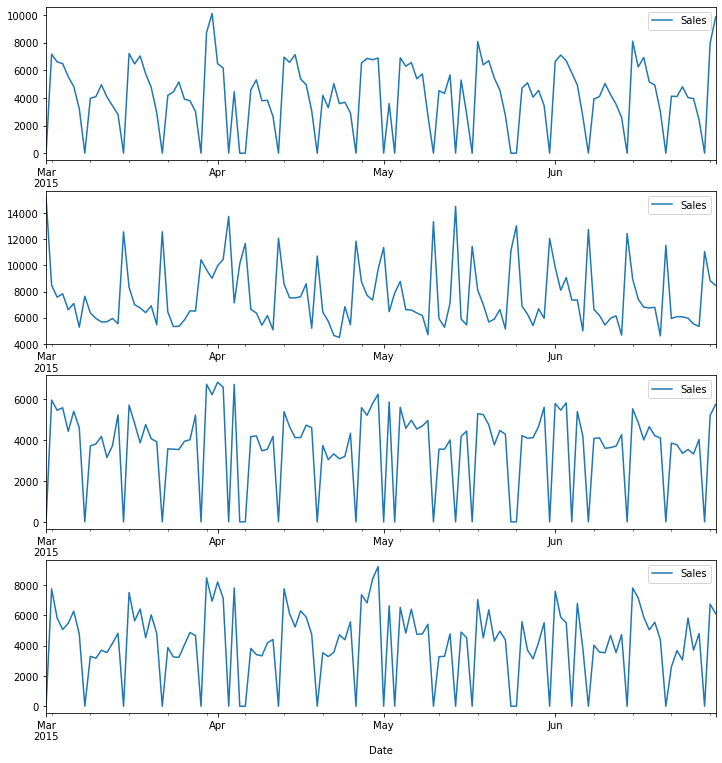

In [11]:

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a['2015-03-01':'2015-06-30'].plot(ax = ax1)
sales_b['2015-03-01':'2015-06-30'].plot(ax = ax2)
sales_c['2015-03-01':'2015-06-30'].plot(ax = ax3)
sales_d['2015-03-01':'2015-06-30'].plot(ax = ax4)
plt.show()

##  -> Ici, on va rearder la moyenne mobile et l’écart-type mobile (sur 12 jours) afin de determiner si la série est stationnaire:
On n'observe qu'une seule boutique à la fois.

Cette boutique est observé d 01 janvier 2013 au 30 juin 2015

$\textbf{Si les deux moyennes mobiles restent constantes au cours du temps (droites et parallèles à l'axe des absisces) alors la série est stationnaire.}$

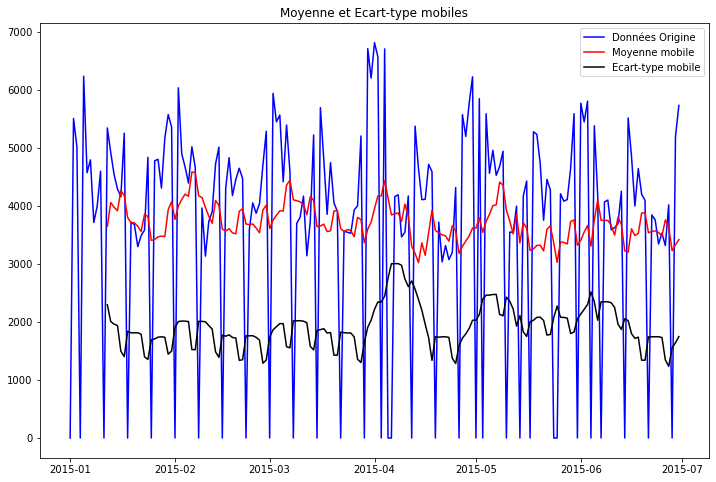

In [12]:
rolling_mean = sales_c['2015-01-01':'2015-06-30'].rolling(window = 12).mean()
rolling_std = sales_c['2015-01-01':'2015-06-30'].rolling(window = 12).std()

plt.figure(figsize = (12, 8))
plt.plot(sales_c['2015-01-01':'2015-06-30'], color = 'blue', label = 'Données Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

La série est stationnaire si: $\textbf{La p-value est inférieure au seuil de 0,05 et la statistique ADF est proche des valeurs critiques}$

On obtient:

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
result = adfuller(sales_d['Sales'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -6.0115359723858335
p-value : 1.5692125686123577e-07
Valeurs Critiques :
	1%: -3.4392539652094154
	5%: -2.86546960465041
	10%: -2.5688625527782327


<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Le modèle AR </h1>

In [15]:
from statsmodels.tsa.ar_model import AutoReg

X_train=sales_a['2015-03-01':'2015-06-30'].asfreq('d')

# train autoregression
model = AutoReg(X_train, lags=7,old_names=True)
model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)

#print('Coefficients: %s' % model_fit.params)
# make predictions
X_pred = model_fit.predict(start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False)
X_test = sales_a['2015-07-01':'2015-07-31']
from sklearn.metrics import r2_score
r2_score(X_test, X_pred)

0.2849864515141879

In [16]:
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(X_test,X_pred))

1687.7998727506094

In [17]:
kaggle_error_vrai(X_pred,X_test)

0.28822685642448415

In [18]:
kaggle_error_vrai_2(X_pred,X_test)

0.26898959451257265

On va essayer de trouver la valeur optimale de p pour AR(p)

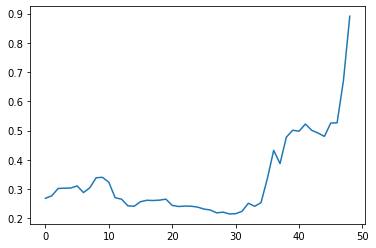

Index du min 29
Valeur min 0.21520627469027367


In [19]:
val_score = []
for k in range(1, 50):
    score1 = kaggle_error_vrai(AutoReg(X_train, lags=k,old_names=True).fit().predict(start=pd.to_datetime('2015-07-01'), 
                                                            end=pd.to_datetime('2015-07-31'), 
                                                            dynamic=False), X_test)
    val_score.append(score1)
min_value = min(val_score)
min_index = val_score.index(min_value)
plt.plot(val_score)
plt.show()

print('Index du min',min_index)
print('Valeur min',min_value)

In [20]:
model = AutoReg(X_train, lags=30,old_names=True)
model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)
X_pred = model_fit.predict(start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False)
X_test = sales_a['2015-07-01':'2015-07-31']

print('pour p=30 on a:')
print('RMSE = ',np.sqrt(metrics.mean_squared_error(X_test,X_pred)))
print('RMSPE_1 = ',kaggle_error_vrai(X_pred,X_test))
print('RMSPE_2 = ',kaggle_error_vrai_2(X_pred,X_test))

pour p=30 on a:
RMSE =  1008.3987144946727
RMSPE_1 =  0.21520627469027367
RMSPE_2 =  0.20084266013103066


In [21]:
X_pred_2=X_pred.reset_index()
X_pred_2.iloc[[0]]#il est devenu un dataframe, X_pred est un time series
#X_pred_2.apply(pd.DataFrame.to_numpy).to_numpy()

,index,0
0,2015-07-01,6237.653078


C'est beacoup mieux qu'avec nos simples modèles linéaires :) !!

## Généralisation :

ici, on code une fonction qui prends en entrée des données et un entier k
Cette fonction va sélectionner le meilleur modèle AR(p) avec 1<=p<=n.
$\textbf{Dans train on va du 1 ermars au 30 juin 2015. Dans les test on va du 1 er jullet au 31 juillet}$
Mettre les dates en paramètres ?


On fait des plots aussi.

In [22]:
def AR_fonc(data, n, start_train, end_train, start_test, end_test):# n est la valeur max de p
    from statsmodels.tsa.ar_model import AutoReg
    from sklearn import metrics
    from sklearn.metrics import r2_score

    
    X_train=data[start_train:end_train].asfreq('d')
    X_test = data[start_test:end_test]

###################### regression #############################
    val_score = []
    for k in range(1, (n+1)):
        score1 = kaggle_error_vrai(AutoReg(X_train, lags=k,
                                           old_names=True).fit().predict(
            start=pd.to_datetime(start_test), end=pd.to_datetime(end_test), dynamic=False), X_test)
        val_score.append(score1)
    min_value = min(val_score)
    min_index = val_score.index(min_value)
    
    model = AutoReg(X_train, lags= (min_index+1),old_names=True)# k entier et index commence à 0
    model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)
    X_pred = model_fit.predict(start=pd.to_datetime(start_test), end=pd.to_datetime(end_test), dynamic=False)
    
################# Plot ###############################################
    plt.figure(figsize=(12,8))
    data.loc[start_train:,'Sales'].plot(label='Données',c="blue")
    pd.DataFrame(X_pred,columns=['Sales']).loc[start_test:,'Sales'].plot(label='Prédictions',c="red",ls='--', lw=5)
    plt.legend()
    plt.show()
############### Metrics ##############################################

    rmse=np.sqrt(metrics.mean_squared_error(X_test,X_pred))
    r_squared =r2_score(X_test, X_pred)
    rmspe = kaggle_error_vrai(X_pred,X_test)

    return model_fit,  r_squared, rmse, rmspe

In [23]:
def AR_fonc_RMSE(data, n, start_train, end_train, start_test, end_test):# n est la valeur max de p
    from statsmodels.tsa.ar_model import AutoReg
    from sklearn import metrics
    from sklearn.metrics import r2_score

    
    X_train=data[start_train:end_train].asfreq('d')
    X_test = data[start_test:end_test]

###################### regression #############################
    val_score = []
    for k in range(1, (n+1)):
        score1 = np.sqrt( metrics.mean_squared_error( X_test, AutoReg(X_train, lags=k,
                                           old_names=True).fit().predict(
            start=pd.to_datetime(start_test), end=pd.to_datetime(end_test), dynamic=False) ))
        val_score.append(score1)
    min_value = min(val_score)
    min_index = val_score.index(min_value)
    
    model = AutoReg(X_train, lags= (min_index+1),old_names=True)# k entier et index commence à 0
    model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)
    X_pred = model_fit.predict(start=pd.to_datetime(start_test), end=pd.to_datetime(end_test), dynamic=False)
    
################# Plot ###############################################
    plt.figure(figsize=(12,8))
    data.loc[start_train:,'Sales'].plot(label='Données',c="blue")
    pd.DataFrame(X_pred,columns=['Sales']).loc[start_test:,'Sales'].plot(label='Prédictions',c="red",ls='--', lw=5)
    plt.legend()
    plt.show()
############### Metrics ##############################################

    rmse=np.sqrt(metrics.mean_squared_error(X_test,X_pred))
    r_squared =r2_score(X_test, X_pred)
    rmspe = kaggle_error_vrai(X_pred,X_test)
    print(X_pred)

    return model_fit,  r_squared, rmse, rmspe

## Store type a:

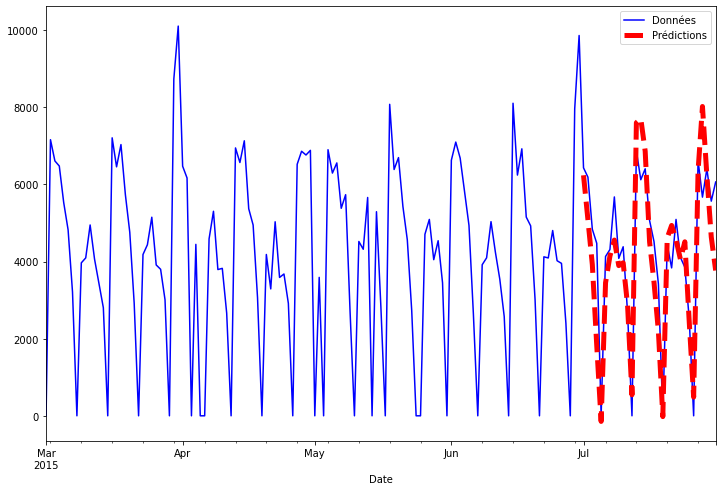

$R^2$ vaut: 0.7447669335471487
Le RMSE vaut: 1008.3987144946727
Le RMSPE vaut: 0.21520627469027367


In [24]:
model1, rcarré, rmse, rmspe = AR_fonc(data=sales_a, n=50, start_train='2015-03-01',  end_train='2015-06-30',
                                      start_test='2015-07-01', end_test='2015-07-31')
print(r'$R^2$ vaut:',rcarré)
print('Le RMSE vaut:',rmse)
print('Le RMSPE vaut:',rmspe)

## Store type b:

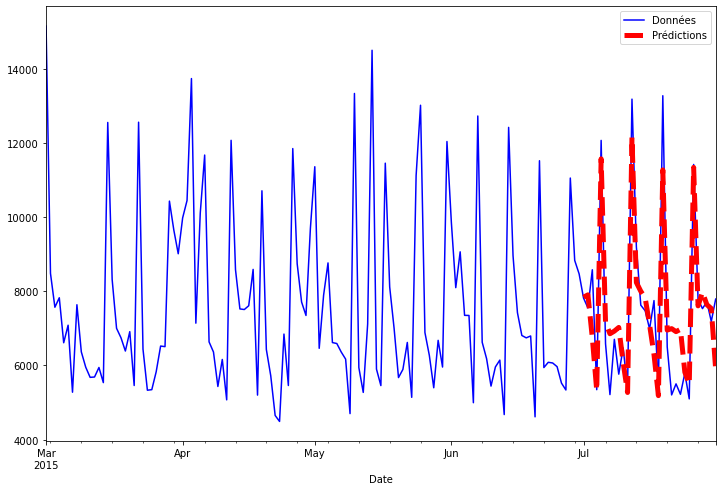

$R^2$ vaut: 0.8093893078742923
Le RMSE vaut: 976.1278747648868
Le RMSPE vaut: 0.1462579246007777


In [25]:
model1, rcarré, rmse, rmspe = AR_fonc(data=sales_b, n=50, start_train='2015-03-01',  end_train='2015-06-30',
                                      start_test='2015-07-01', end_test='2015-07-31')
print(r'$R^2$ vaut:',rcarré)
print('Le RMSE vaut:',rmse)
print('Le RMSPE vaut:',rmspe)

## Store type c:

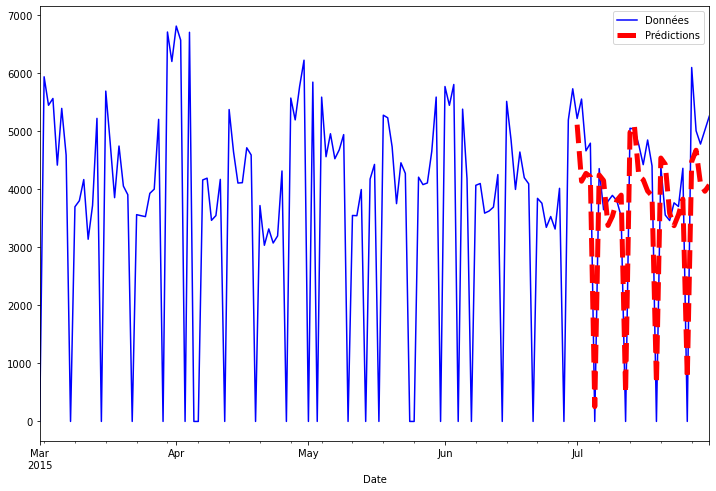

$R^2$ vaut: 0.8444927277763012
Le RMSE vaut: 644.3908329753119
Le RMSPE vaut: 0.13354374726823134


In [26]:
model1, rcarré, rmse, rmspe = AR_fonc(data=sales_c, n=50, start_train='2015-03-01',  end_train='2015-06-30',
                                      start_test='2015-07-01', end_test='2015-07-31')
print(r'$R^2$ vaut:',rcarré)
print('Le RMSE vaut:',rmse)
print('Le RMSPE vaut:',rmspe)

## Store type d:

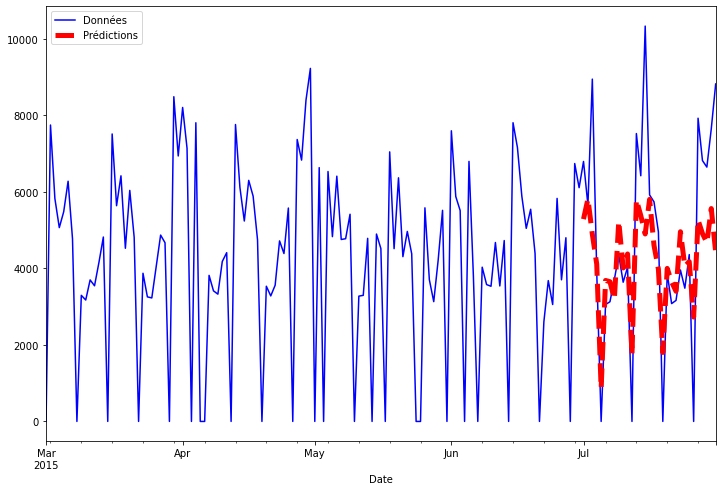

$R^2$ vaut: 0.489246699442796
Le RMSE vaut: 1893.2114065769401
Le RMSPE vaut: 0.24157573874371485


In [27]:
model1, rcarré, rmse, rmspe = AR_fonc(data=sales_d, n=50, start_train='2015-03-01',  end_train='2015-06-30',
                                      start_test='2015-07-01', end_test='2015-07-31')
print(r'$R^2$ vaut:',rcarré)
print('Le RMSE vaut:',rmse)
print('Le RMSPE vaut:',rmspe)

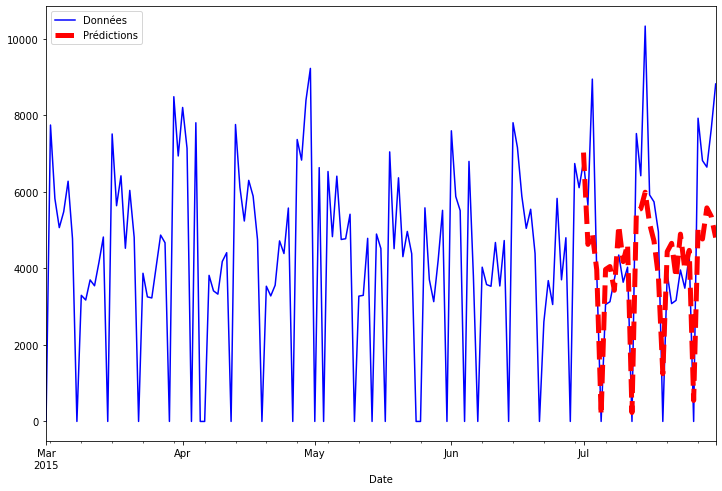

2015-07-01    7027.825089
2015-07-02    4627.675174
2015-07-03    4919.239378
2015-07-04    3963.577816
2015-07-05     164.433301
2015-07-06    3972.889760
2015-07-07    4049.034898
2015-07-08    3426.994606
2015-07-09    5120.371645
2015-07-10    4177.218701
2015-07-11    4631.257866
2015-07-12     231.843108
2015-07-13    5494.111701
2015-07-14    5560.810021
2015-07-15    5991.776958
2015-07-16    5168.343443
2015-07-17    4714.380709
2015-07-18    3791.753386
2015-07-19    1245.904498
2015-07-20    4438.620525
2015-07-21    4655.235423
2015-07-22    3759.845558
2015-07-23    4896.013681
2015-07-24    3975.869671
2015-07-25    4472.022340
2015-07-26     547.359533
2015-07-27    5018.905380
2015-07-28    4768.640323
2015-07-29    5582.170814
2015-07-30    5358.354582
2015-07-31    4807.458130
Freq: D, dtype: float64
$R^2$ vaut: 0.5935817780704247
Le RMSE vaut: 1688.8073377160354
Le RMSPE vaut: 0.25879328623558306


In [28]:
model1, rcarré, rmse, rmspe = AR_fonc_RMSE(data=sales_d, n=50, start_train='2015-03-01',  end_train='2015-06-30',
                                      start_test='2015-07-01', end_test='2015-07-31')
print(r'$R^2$ vaut:',rcarré)
print('Le RMSE vaut:',rmse)
print('Le RMSPE vaut:',rmspe)

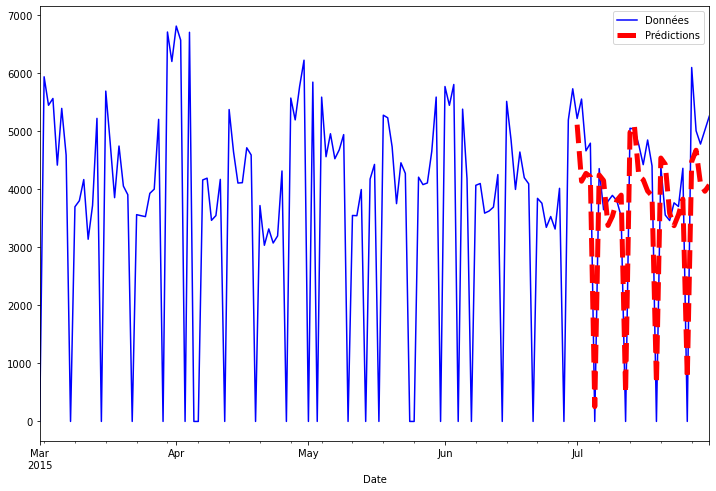

2015-07-01    5115.941397
2015-07-02    4141.914330
2015-07-03    4276.868819
2015-07-04    4218.511286
2015-07-05     255.093306
2015-07-06    4249.011705
2015-07-07    4152.928485
2015-07-08    3379.021954
2015-07-09    3538.204262
2015-07-10    3808.286083
2015-07-11    3902.095480
2015-07-12     490.078651
2015-07-13    4983.132444
2015-07-14    5098.635858
2015-07-15    4231.085033
2015-07-16    4167.230131
2015-07-17    3972.313051
2015-07-18    3890.378303
2015-07-19     650.941576
2015-07-20    4540.860245
2015-07-21    4433.818713
2015-07-22    3587.092035
2015-07-23    3374.558018
2015-07-24    3563.739376
2015-07-25    3833.276535
2015-07-26     740.665712
2015-07-27    4480.851324
2015-07-28    4675.730672
2015-07-29    4096.887251
2015-07-30    3968.636039
2015-07-31    4076.829098
Freq: D, dtype: float64


In [29]:
#train2[train2.Store == 1][['Sales']].sort_index(ascending = True)
model1, rcarré, rmse, rmspe = AR_fonc_RMSE(data=train2[train2.Store == 1][['Sales']].sort_index(ascending = True), n=50, start_train='2015-03-01',  end_train='2015-06-30',
                                     start_test='2015-07-01', end_test='2015-07-31')

## Ici, on va créer notre fonction qui va séparer nos données par store (1115-Fold par Id ):

In [30]:
# I faut que X ait une colonne store
def Sep_stores(X):
    res=[]
    K=1115
    for k in range(1, (K+1) ): 
        tmp = X[X.Store == k][['Sales']].sort_index(ascending = True)
        res.append(tmp)   
    return res

In [31]:
Fold_Stores=Sep_stores(train2)
for i in range(10):
    print(Fold_Stores[i].shape)
Fold_Stores[0]

(942, 1)
(942, 1)
(942, 1)
(942, 1)
(942, 1)
(942, 1)
(942, 1)
(942, 1)
(942, 1)
(942, 1)


,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
...,...
2015-07-27,6102
2015-07-28,5011
2015-07-29,4782


In [32]:
Fold_Stores[0]

,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
...,...
2015-07-27,6102
2015-07-28,5011
2015-07-29,4782


In [33]:
train2[train2.Store == 1][['Sales']].sort_index(ascending = True)

,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997
...,...
2015-07-27,6102
2015-07-28,5011
2015-07-29,4782


In [45]:
n=50
start_train='2015-02-15'
end_train='2015-05-31'
start_test='2015-06-01'
end_test='2015-07-31'
from statsmodels.tsa.arima.model import ARIMA


res=Fold_Stores[0].reset_index().iloc[[0]]
print(res)
for f in [0,2]:  
    X_train=Fold_Stores[f][start_train:end_train].asfreq('d')
    X_test=Fold_Stores[f][start_test:end_test]
    X_final=Fold_Stores[f][start_train:end_test].asfreq('d')
###################### regression #############################
    val_score = []
    for k in range(10, (n+1)):
        #kaggle_error_vrai(AutoReg(X_train, lags=k,old_names=True).fit().predict(
        score1 = kaggle_error_vrai(AutoReg(X_train, lags=k,old_names=True).fit().predict(start=pd.to_datetime(start_test), end=pd.to_datetime(end_test), dynamic=False), X_test)
        val_score.append(score1)
        min_value = min(val_score)
        min_index = val_score.index(min_value)
    
    print(min_index)
    X_final=Fold_Stores[f]['2015-06-01':'2015-07-31'].asfreq('d')
    model = AutoReg(X_final, lags=min_index+10,old_names=True)# k entier et index commence à 0
    model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)
    X_pred = model_fit.predict(start=pd.to_datetime('2015-08-01'), end=pd.to_datetime('2015-09-17'), dynamic=False)
    ##################
    
    print('avant reset index:',X_pred)
    X_pred=X_pred.reset_index()
    X_pred.rename(columns = {'index' : 'Date', 0 : 'Sales'}, inplace = True)
    print('avant les modifs:',X_pred)
    res=pd.concat([res,X_pred],ignore_index=True,axis=0)

res=res.drop(0)
#res.info() 
res


        Date  Sales
0 2013-01-01      0
5
avant reset index: 2015-08-01    4720.659247
2015-08-02    -337.282002
2015-08-03    4988.447717
2015-08-04    3407.611036
2015-08-05    3074.606490
2015-08-06    3329.311432
2015-08-07    3944.008145
2015-08-08    4049.610956
2015-08-09    -130.780885
2015-08-10    5846.461324
2015-08-11    4702.184299
2015-08-12    4817.023062
2015-08-13    5099.164634
2015-08-14    5361.698938
2015-08-15    4793.062379
2015-08-16     -35.344009
2015-08-17    5115.877346
2015-08-18    3216.609639
2015-08-19    3063.664753
2015-08-20    3313.556112
2015-08-21    3860.573377
2015-08-22    3808.039596
2015-08-23    -165.855980
2015-08-24    5709.127589
2015-08-25    4379.591879
2015-08-26    4792.320014
2015-08-27    5188.896516
2015-08-28    5516.792282
2015-08-29    4887.552957
2015-08-30     281.554562
2015-08-31    5275.787982
2015-09-01    3101.414992
2015-09-02    3111.011542
2015-09-03    3319.148077
2015-09-04    3798.030767
2015-09-05    3598.122085
201

,Date,Sales
1,2015-08-01,4720.659247
2,2015-08-02,-337.282002
3,2015-08-03,4988.447717
4,2015-08-04,3407.611036
5,2015-08-05,3074.606490
...,...,...
92,2015-09-13,3912.557937
93,2015-09-14,8099.044571
94,2015-09-15,8402.594524
95,2015-09-16,7908.383507


In [35]:
res.iloc[0:50,]

,Date,Sales
1,2015-08-01,4539.297288
2,2015-08-02,636.056466
3,2015-08-03,5002.172992
4,2015-08-04,4112.626207
5,2015-08-05,3739.179961
6,2015-08-06,3919.149396
7,2015-08-07,4199.425553
8,2015-08-08,4193.684263
9,2015-08-09,586.966496
10,2015-08-10,5396.360244


In [36]:
res2=res.sort_values(by='Date',ascending=False) 
res2
########## 1111111111

,Date,Sales
96,2015-09-17,6920.844030
48,2015-09-17,4184.220932
47,2015-09-16,3926.141428
95,2015-09-16,6287.885308
46,2015-09-15,4195.043040
...,...,...
51,2015-08-03,6994.140602
50,2015-08-02,892.095796
2,2015-08-02,636.056466
1,2015-08-01,4539.297288


In [37]:
res2.iloc[0:20,]

,Date,Sales
96,2015-09-17,6920.844030
48,2015-09-17,4184.220932
47,2015-09-16,3926.141428
95,2015-09-16,6287.885308
46,2015-09-15,4195.043040
94,2015-09-15,7059.066029
45,2015-09-14,5158.263134
93,2015-09-14,6786.590609
92,2015-09-13,2077.350376
44,2015-09-13,1378.441573


In [38]:
res3=res2.reset_index(drop=False)
res3
########## 2222222222222222

,index,Date,Sales
0,96,2015-09-17,6920.844030
1,48,2015-09-17,4184.220932
2,47,2015-09-16,3926.141428
3,95,2015-09-16,6287.885308
4,46,2015-09-15,4195.043040
...,...,...,...
91,51,2015-08-03,6994.140602
92,50,2015-08-02,892.095796
93,2,2015-08-02,636.056466
94,1,2015-08-01,4539.297288


In [39]:
res3.iloc[0:2]=res3.iloc[0:2].sort_values(by='index',ascending=True) 
res3
###########MTN FAUT UNE BOUCLE AVEC LE BOn PAS ############ 333333333333333
#ici le pas est de 2 car on regarde que deux séries
#mais dans notre fonction finale le pas sera: len(indices_alt)

#qd tout sera bon: faudrasupprimer la colonne index et reset index (chunk suivant)

,index,Date,Sales
0,48,2015-09-17,4184.220932
1,96,2015-09-17,6920.844030
2,47,2015-09-16,3926.141428
3,95,2015-09-16,6287.885308
4,46,2015-09-15,4195.043040
...,...,...,...
91,51,2015-08-03,6994.140602
92,50,2015-08-02,892.095796
93,2,2015-08-02,636.056466
94,1,2015-08-01,4539.297288


In [40]:
res2.reset_index(drop=True)

,Date,Sales
0,2015-09-17,6920.844030
1,2015-09-17,4184.220932
2,2015-09-16,3926.141428
3,2015-09-16,6287.885308
4,2015-09-15,4195.043040
...,...,...
91,2015-08-03,6994.140602
92,2015-08-02,892.095796
93,2015-08-02,636.056466
94,2015-08-01,4539.297288


In [41]:
#list(test['Store'].unique())#indices des stores qui sont dans test

In [38]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [39]:
indices_fermes=test.index[test['Open'] == 0].tolist()
indices_fermes

[543,
 676,
 840,
 1399,
 1532,
 1696,
 2255,
 2388,
 2552,
 3111,
 3244,
 3408,
 3424,
 3425,
 3426,
 3427,
 3428,
 3429,
 3430,
 3431,
 3432,
 3433,
 3434,
 3435,
 3436,
 3437,
 3438,
 3439,
 3440,
 3441,
 3442,
 3443,
 3444,
 3445,
 3446,
 3447,
 3448,
 3449,
 3450,
 3451,
 3452,
 3453,
 3454,
 3455,
 3456,
 3457,
 3458,
 3459,
 3460,
 3461,
 3462,
 3463,
 3464,
 3465,
 3466,
 3467,
 3468,
 3469,
 3470,
 3471,
 3472,
 3473,
 3474,
 3475,
 3476,
 3477,
 3478,
 3479,
 3480,
 3481,
 3482,
 3483,
 3484,
 3485,
 3486,
 3487,
 3488,
 3489,
 3490,
 3491,
 3492,
 3493,
 3494,
 3495,
 3496,
 3497,
 3498,
 3499,
 3500,
 3501,
 3502,
 3503,
 3504,
 3505,
 3506,
 3507,
 3508,
 3509,
 3510,
 3511,
 3512,
 3513,
 3514,
 3516,
 3517,
 3518,
 3519,
 3520,
 3521,
 3522,
 3523,
 3524,
 3525,
 3526,
 3527,
 3528,
 3529,
 3530,
 3531,
 3532,
 3533,
 3534,
 3535,
 3536,
 3537,
 3538,
 3539,
 3540,
 3541,
 3542,
 3543,
 3544,
 3545,
 3546,
 3547,
 3548,
 3549,
 3550,
 3551,
 3552,
 3553,
 3554,
 3555,
 3

# Notre fonction finale 1:

In [61]:
def AR_final(data,data_comparaison, indices_alt, n, start_train, end_train, start_test, end_test):# n est la valeur max de p
    #data corresponds à notre 1115-Fold
    ####"indices_alt sont les indices pris en compte
    ####AYTTENTIOn": au max va de 0 à 1114
    #c'est une liste
    
    from statsmodels.tsa.ar_model import AutoReg
    from sklearn import metrics
    from sklearn.metrics import r2_score
    
    res=data[0].reset_index().iloc[[0]]

    for f in indices_alt:  # boucle des indices qui voint être pris en compte
        
        X_train=Fold_Stores[f-1][start_train:end_train].asfreq('d')
        X_test=Fold_Stores[f-1][start_test:end_test]#.asfreq('d')
    ###################### regression #############################
        val_score = []
        for k in range(10, (n+1)):
            score1 = kaggle_error_vrai(AutoReg(X_train, lags=k,
                                               old_names=True).fit().predict(
                start=pd.to_datetime(start_test), end=pd.to_datetime(end_test), dynamic=False), X_test)
            val_score.append(score1)
        min_value = min(val_score)
        min_index = val_score.index(min_value)

        model = AutoReg( Fold_Stores[f-1]['2015-04-01':'2015-07-31'].asfreq('d') , lags= (min_index+10),old_names=True)# k entier et index commence à 0
        model_fit = model.fit()#.fit(disp=0) pour cacher (ou -1)
        X_pred = model_fit.predict(start=pd.to_datetime('2015-08-01'), end=pd.to_datetime('2015-09-17'), dynamic=False)
        ##################
        X_pred=X_pred.reset_index()
        X_pred.rename(columns = {'index' : 'Date', 0 : 'Sales'}, inplace = True)
        res=pd.concat([res,X_pred],ignore_index=True,axis=0)

    res=res.drop(0)
    #res2=res.sort_values(by='Date',ascending=False) # pour les ranger dans l'ordre par indices puis par dates
    #res2.reset_index(drop=True, inplace=True)
    #res2.loc[data_comparaison['Open']==0,'Sales']= 0 #astuce de fixer les zéros
    #res2.index = res2.index + 1
    return res

In [63]:
indices_in_test=list(test['Store'].unique())
submission_1 = AR_final(data=Fold_Stores,data_comparaison=test ,indices_alt=indices_in_test, n=40, 
                        start_train='2014-04-01',end_train='2014-07-31',start_test='2014-08-01', end_test='2014-09-17')


In [64]:
submission2=submission_1.sort_values(by='Date',ascending=False) 


submission_2=submission2.reset_index(drop=False)



paas=len(indices_in_test)


for i in range(47):## Non essyé avec 47
    submission_2.iloc[i*paas:(i+1)*paas]=submission_2.iloc[i*paas:(i+1)*paas].sort_values(by='index',ascending=True) 

###########MTN FAUT UNE BOUCLE AVEC LE BOn PAS ############ 333333333333333
#ici le pas est de 2 car on regarde que deux séries
#mais dans notre fonction finale le pas sera: len(indices_alt)

#qd tout sera bon: faudrasupprimer la colonne index et reset index (chunk suivant)


submission_2.reset_index(drop=True, inplace=True)
submission_2.loc[test['Open']==0,'Sales']= 0 #astuce de fixer les zéros
submission_2.index = submission_2.index + 1

In [65]:
submission_1.head()

,Date,Sales
1,2015-08-01,3658.372975
2,2015-08-02,276.459721
3,2015-08-03,4207.806137
4,2015-08-04,3321.080720
5,2015-08-05,2725.136255


In [66]:
submission_2.head()

,index,Date,Sales
1,48,2015-09-17,3828.419317
2,96,2015-09-17,7177.224423
3,144,2015-09-17,10483.969950
4,192,2015-09-17,6577.879267
5,240,2015-09-17,7507.852513


In [67]:
submission_1[['Sales']].to_csv('submission2_1.csv', encoding='utf-8')# fichier par boutique à la suite
submission_2[['Sales']].to_csv('submission2_2.csv', encoding='utf-8')# le bon bien rangé

récupérer le code au dessus:
On récupère la colonne Open de test, on la concatène avec notre resultat final et on fait:

    res.loc[res['Open']==0,'Sales']= 0
    
    
    Ou bien mm pas besoin de concaténer, on fait: res.loc[test['Open']==0,'Sales']= 0  ????

In [ ]:
sales_b.loc['2014-01-01':'2014-12-31','Sales'].plot(label='Données',c="blue")

In [ ]:
sales_b.loc['2015-01-01':,'Sales'].plot(label='Données',c="blue")

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Le modèle ARMA </h1>

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
X_train=sales_d['2015-03-01':'2015-06-30'].asfreq('d')

################# les warnings enlevé =danger. Modèle final doit fonctionner sans ######
model = ARIMA(X_train, order=(30,0,20))# les flases car on est
#en train de tester. On a pas encore les bons paramètres
model_fit = model.fit()# pour éviter erreur warnings sur la liklihood qui ne 
#converge pas

X_pred = model_fit.predict(start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False)

X_test = sales_d['2015-07-01':'2015-07-31']
r2_score(X_test, X_pred)

In [ ]:
print(kaggle_error_vrai(X_pred,X_test))
print(np.sqrt(metrics.mean_squared_error(X_test,X_pred)))

In [ ]:
X_train=sales_c['2015-03-01':'2015-06-30'].asfreq('d')
X_test = sales_c['2015-07-01':'2015-07-31']

val_score = []

for k1 in range(40):
        score1 = kaggle_error_vrai(ARIMA(X_train, order=(k1,0,30),enforce_stationarity=False,enforce_invertibility=False
                                        ).fit(method_kwargs={"warn_convergence": False}).predict(
            start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False), X_test)    
        val_score.append(score1)

min_value = min(val_score)
min_index = val_score.index(min_value)
plt.plot(val_score)
plt.show()

print('Index du min',min_index)
print('Valeur min',min_value)

<h1  style="color:white; background-color:#808b96; border-radius: 10px; padding:15px;"> Le modèle ARIMA </h1>

In [ ]:
X_train=sales_d['2015-01-01':'2015-06-30'].asfreq('d')

################# les warnings enlevé =danger. Modèle final doit fonctionner sans ######
model = ARIMA(X_train, order=(20,1,20),enforce_stationarity=False,enforce_invertibility=False)# les flases car on est
#en train de tester. On a pas encore les bons paramètres
model_fit = model.fit(method_kwargs={"warn_convergence": False})# pour éviter erreur warnings sur la liklihood qui ne 
#converge pas

X_pred = model_fit.predict(start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False)

X_test = sales_d['2015-07-01':'2015-07-31']
r2_score(X_test, X_pred)

In [ ]:
print(kaggle_error_vrai(X_pred,X_test))
print(np.sqrt(metrics.mean_squared_error(X_test,X_pred)))

In [ ]:
X_train=sales_d['2015-03-01':'2015-06-30'].asfreq('d')
X_test = sales_d['2015-07-01':'2015-07-31']

val_score = []

for k1 in range(40):
        score1 = kaggle_error_vrai(ARIMA(X_train, order=(k1,1,2),enforce_stationarity=False,enforce_invertibility=False
                                        ).fit(method_kwargs={"warn_convergence": False}).predict(
            start=pd.to_datetime('2015-07-01'), end=pd.to_datetime('2015-07-31'), dynamic=False), X_test)    
        val_score.append(score1)

min_value = min(val_score)
min_index = val_score.index(min_value)
plt.plot(val_score)
plt.show()

print('Index du min',min_index)
print('Valeur min',min_value)